# ***Importing modules and Loading datasets***

In [1]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from glob import glob
from keras.models import Sequential
from keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from keras.callbacks import EarlyStopping,LearningRateScheduler
import warnings
from tqdm import tqdm
from PIL import Image
warnings.filterwarnings('ignore')

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='Vehicle_Detection_Image_Set.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Vehicle_Detection_Image_Set.zip')
f.keys()
!unzip Vehicle_Detection_Image_Set.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/vehicles/4414.png  
  inflating: data/vehicles/4415.png  
  inflating: data/vehicles/4416.png  
  inflating: data/vehicles/4417.png  
  inflating: data/vehicles/4418.png  
  inflating: data/vehicles/4419.png  
  inflating: data/vehicles/442.png   
  inflating: data/vehicles/4420.png  
  inflating: data/vehicles/4421.png  
  inflating: data/vehicles/4422.png  
  inflating: data/vehicles/4423.png  
  inflating: data/vehicles/4424.png  
  inflating: data/vehicles/4425.png  
  inflating: data/vehicles/4426.png  
  inflating: data/vehicles/4427.png  
  inflating: data/vehicles/4428.png  
  inflating: data/vehicles/4429.png  
  inflating: data/vehicles/443.png   
  inflating: data/vehicles/4430.png  
  inflating: data/vehicles/4431.png  
  inflating: data/vehicles/4432.png  
  inflating: data/vehicles/4433.png  
  inflating: data/vehicles/4434.png  
  inflating: data/vehicles/4435.png  
  inflating: data/vehicles/4436.png  

In [3]:
df=pd.DataFrame(columns=['image','label'])

In [4]:
# for a picture containing image of vehicle label is 1.

idx=0
for name in tqdm(glob('../content/data/vehicles/*')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[1]},index=[idx])
    df=df.append(data)    
    idx+=1

100%|██████████| 8792/8792 [00:32<00:00, 270.66it/s]


In [5]:
# for a picture doesn't contain image of vehicle label is 0.

for name in tqdm(glob('../content/data/non-vehicles/*')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[0]},index=[idx]) 
    df=df.append(data)
    idx+=1

100%|██████████| 8968/8968 [00:36<00:00, 244.20it/s]


# **Train test spliting of data**

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(df,df['label']):
    train_data=df.iloc[train_index]
    test_data=df.iloc[test_index]
# train_x,test_x,train_y,test_y=train_test_split(df['image'],df['label'],random_state=42,test_size=0.15)

In [7]:
train_img,train_label=train_data['image'],train_data['label']
test_img,test_label=test_data['image'],test_data['label']

# **Data Visualization**

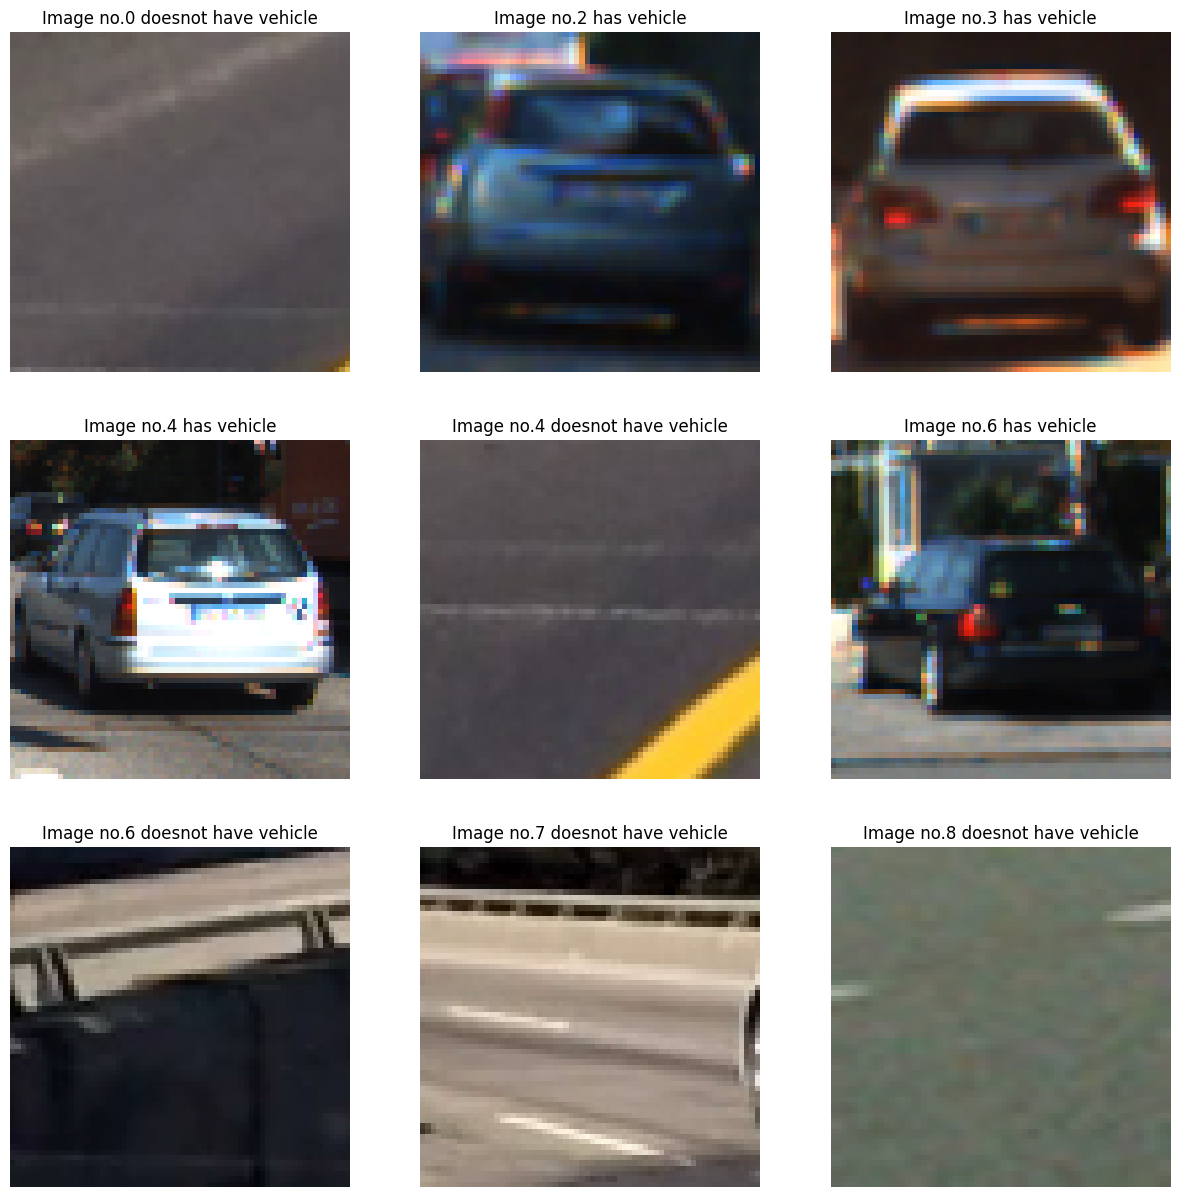

In [8]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    ix=np.random.randint(3000)
    if(train_label.iloc[ix]==1):
        plt.title('Image no.{0} has vehicle'.format(i+1))
    elif(train_label.iloc[ix]==0):
        plt.title('Image no.{0} doesnot have vehicle'.format(i))
    plt.axis('off')
    plt.imshow(train_img.iloc[ix])
plt.show()

# **Changin Dimension of Data**

In [9]:
def change_image_dimension(data):
    data=np.reshape(data.to_list(),(len(data),64,64,3))
    return data

In [10]:
train_img=change_image_dimension(train_img)
test_img=change_image_dimension(test_img)
# train_img
train_img=train_img/255.0
test_img=test_img/255.0

In [11]:
train_label=np.array(train_label,dtype=int)
test_label=np.array(test_label,dtype=int)

# **Callback Functions**

In [12]:
def schedule(epoch,lr):
    if epoch>=5:
        return 0.0001
    return 0.001
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)
learning_rate_scheduler=LearningRateScheduler(schedule)

# **Convolutional Neural Network**

In [14]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()

# Load ResNet50V2 model
resnet = ResNet50V2(include_top=False, input_shape=(64, 64, 3))

# Freeze all layers in the pre-trained model
for layer in resnet.layers:
    layer.trainable = False

# Add the pre-trained model to the Sequential model
model.add(resnet)

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


94668760/94668760 [==============================] - 1s 0us/step


In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
r=model.fit(train_img,train_label,validation_data=(test_img,test_label),epochs=25,batch_size=100)

Epoch 1/25
143/143 [==============================] - 21s 61ms/step - loss: 0.0748 - accuracy: 0.9757 - val_loss: 0.0292 - val_accuracy: 0.9890
Epoch 2/25
143/143 [==============================] - 5s 38ms/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 0.0252 - val_accuracy: 0.9910
Epoch 3/25
143/143 [==============================] - 6s 39ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0305 - val_accuracy: 0.9913
Epoch 4/25
143/143 [==============================] - 5s 38ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0250 - val_accuracy: 0.9921
Epoch 5/25
143/143 [==============================] - 6s 39ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0255 - val_accuracy: 0.9918
Epoch 6/25
143/143 [==============================] - 5s 38ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0238 - val_accuracy: 0.9927
Epoch 7/25
143/143 [==============================] - 6s 39ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0419 - val_accuracy: 0.989

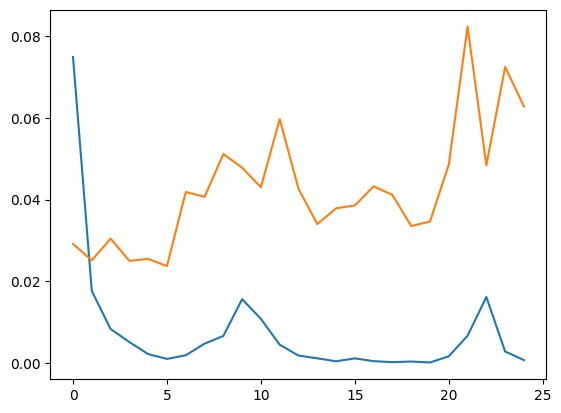

In [17]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

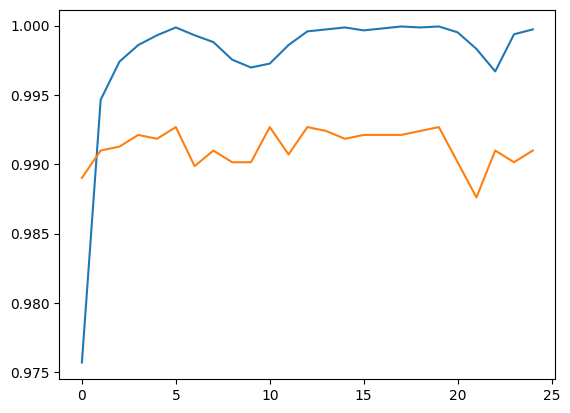

In [18]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

# **Visualization of Predicted Data**

1/1 [==============================] - 0s 25ms/step


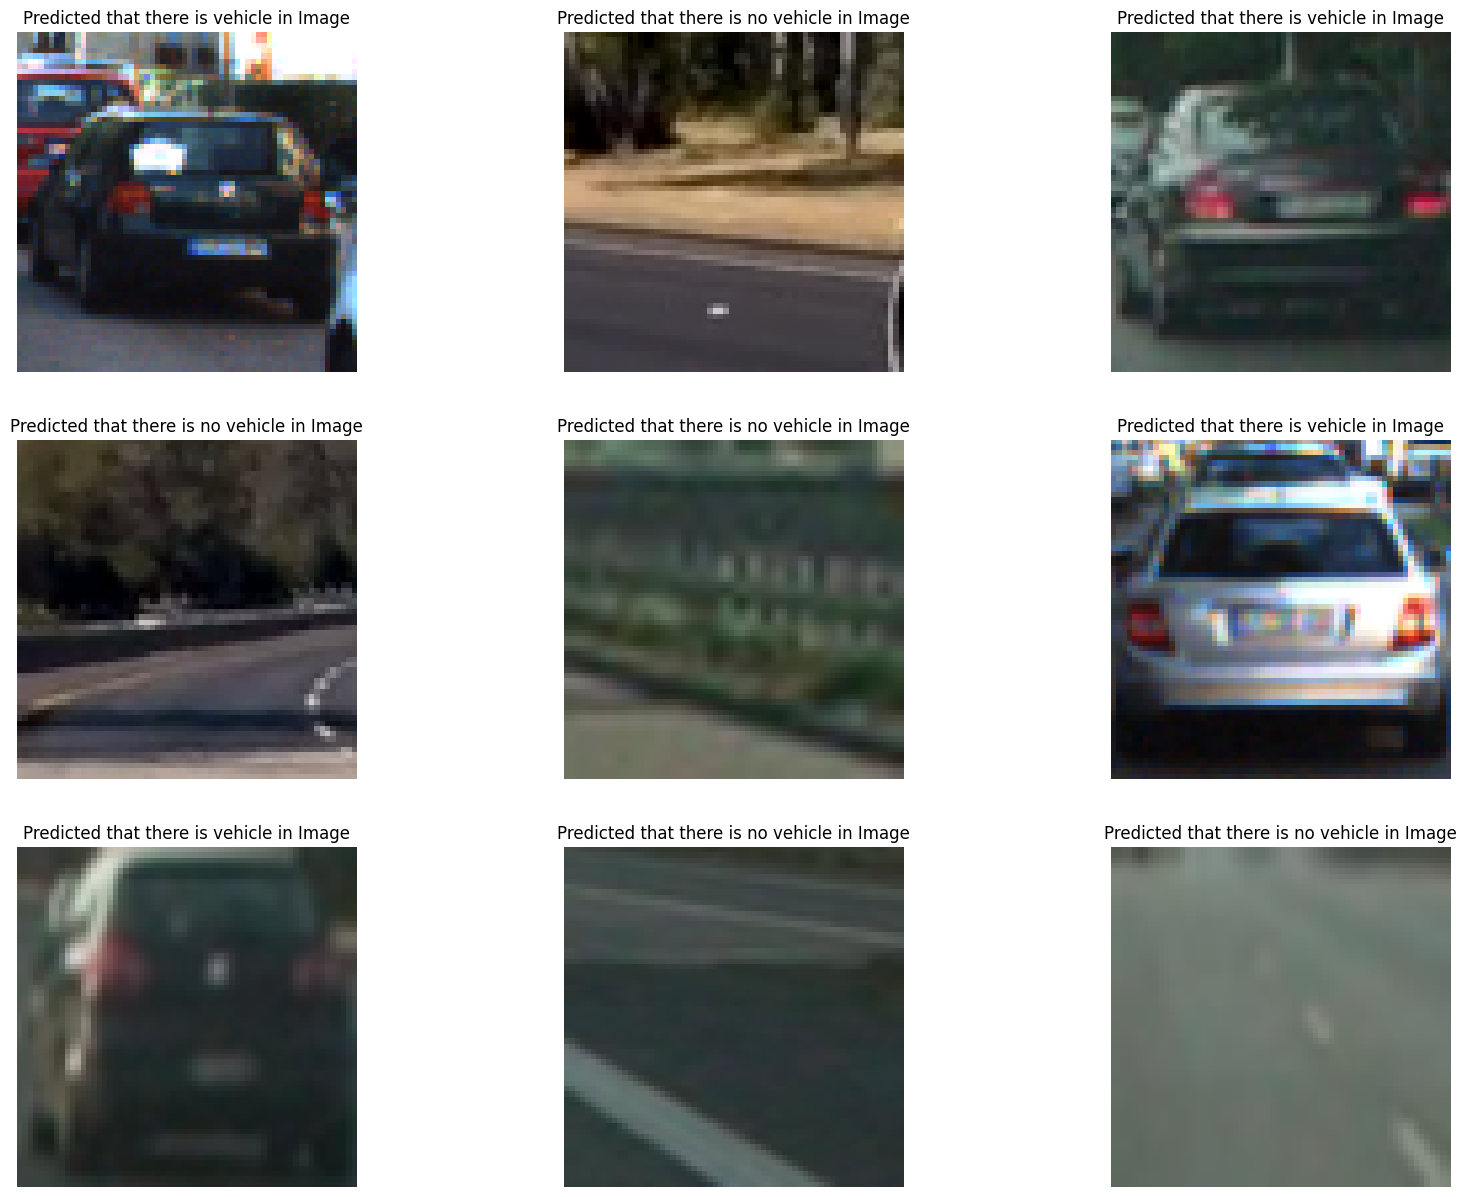

In [19]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    rd_idx=np.random.randint(700)
    pred_test=model.predict(np.reshape(test_img[rd_idx],(-1,64,64,3)))
    if pred_test>=0.99:
        plt.title('Predicted that there is vehicle in Image')
    else:
        plt.title('Predicted that there is no vehicle in Image')
    plt.axis('off')
    plt.imshow(test_img[rd_idx])
plt.show()


# **Testing by UserInput Image**

Saving Scorpio-black-colour-image.jpg to Scorpio-black-colour-image (1).jpg


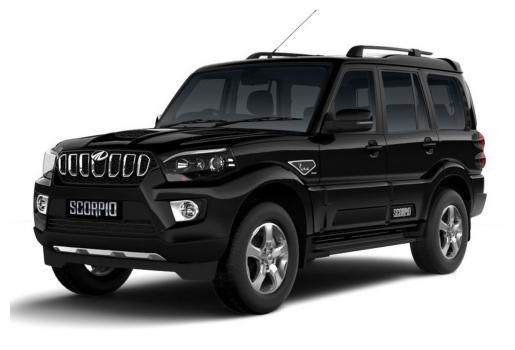

1/1 [==============================] - 0s 24ms/step
Vehicle detected in the image!


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Define a function to preprocess the image
def preprocess_image(img_path):
  img = image.load_img(img_path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.
  return x

# Define a function to predict whether there's a vehicle in the image or not
def predict_vehicle(img_path):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  x = preprocess_image(img_path)
  prediction = model.predict(x)
  if prediction[0][0] != 1:
    print("Vehicle detected in the image!")
  else:
    print("No vehicle detected in the image.")

# Allow the user to upload an image
from google.colab import files
uploaded = files.upload()

# Call the predict_vehicle function for the uploaded image
for fn in uploaded.keys():
  path = fn
  predict_vehicle(path)
